In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

import numpy as np
from PIL import Image
import os, random, datetime
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import gym
from gym import spaces

In [2]:
# 이미지 데이터 위치
base_dir = './archive/kaggle_3m/'

In [3]:
# 이미지 불러오는 함수
def load_images(base_dir):
    mri_images = []
    mask_images = []
    
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        folder_mri_images = []
        folder_mask_images = []
        
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if file_name.endswith('.tif') and not file_name.endswith('_mask.tif'):
                    mri_image_path = os.path.join(folder_path, file_name)
                    mask_image_path = mri_image_path.replace('.tif', '_mask.tif')
                    
                    if os.path.exists(mask_image_path):
                        mri_image = Image.open(mri_image_path)
                        mask_image = Image.open(mask_image_path)
                        
                        folder_mri_images.append(np.array(mri_image))
                        folder_mask_images.append(np.array(mask_image))

        if len(folder_mri_images) > 0:
            mri_images.append(folder_mri_images)
            mask_images.append(folder_mask_images)
            
                        
    return mri_images, mask_images

In [4]:
# mri와 mask 이미지들을 불러오기
mri_images, mask_images = load_images(base_dir)

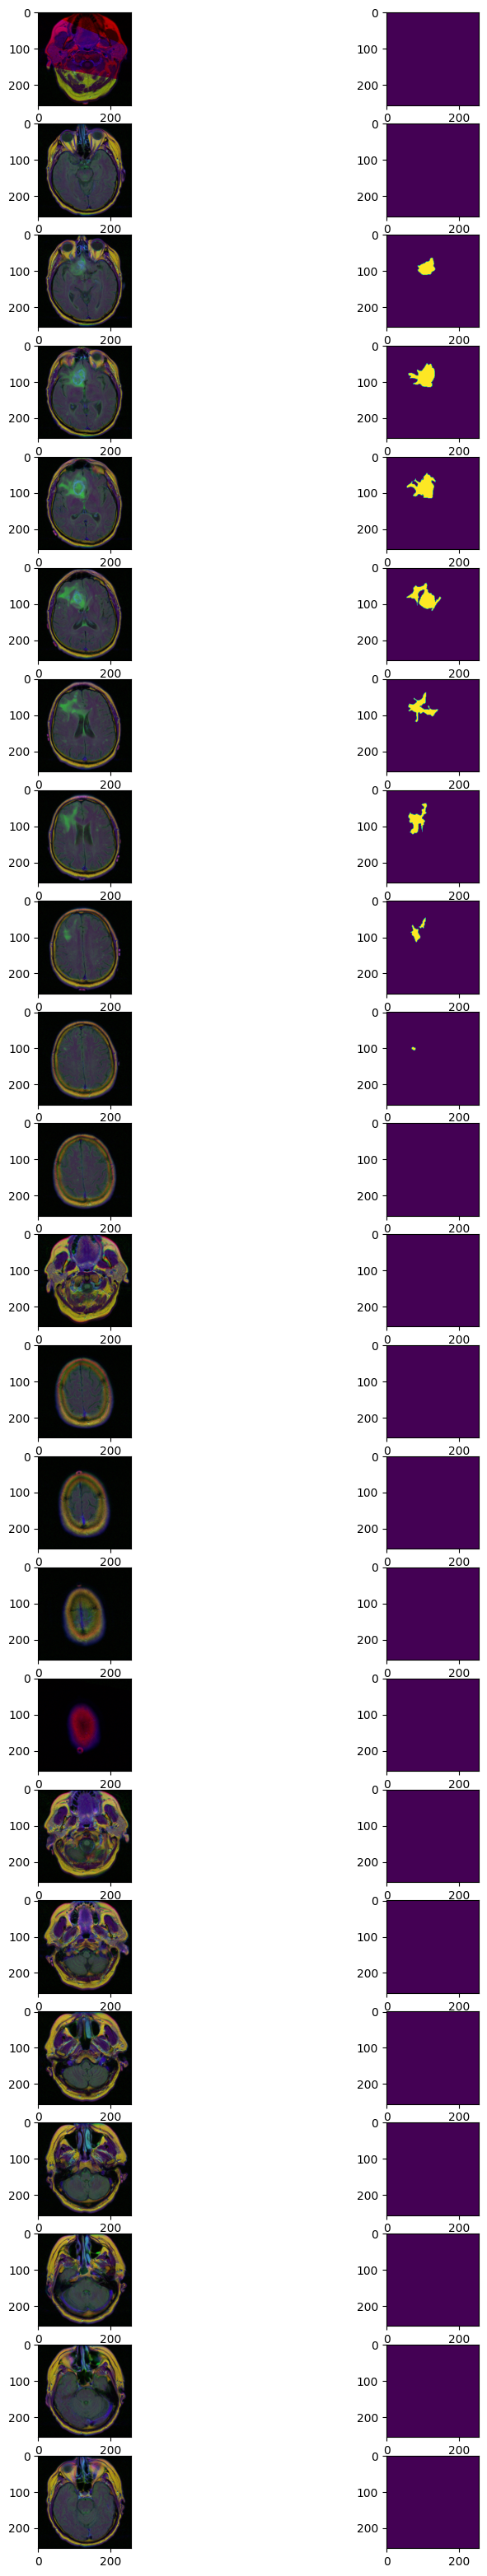

In [5]:
fig = plt.figure(figsize=(10, 40))
ii = 1
for i in range(len(mri_images[0])):
    ax1 = fig.add_subplot(len(mri_images[0]), 2, ii)
    ax2 = fig.add_subplot(len(mri_images[0]), 2, ii+1)
    ax1.imshow(mri_images[0][i])
    ax2.imshow(mask_images[0][i])
    ii+=2
plt.show()

In [6]:
# mask 이미지 정규화
norm_mask_images = []

for folder in mask_images:
    folder_im = []
    for image in folder:
        image[image==255] = 1
        folder_im.append(image)
    norm_mask_images.append(folder_im)

In [7]:
# 한 케이스에 여러 mri 사진과 mask 사진이 있던 것을 여러 mri 사진과 한 mask 사진이 있도록 변경
mask_each_images = []

for folder in norm_mask_images:
    folder_image = np.zeros((256, 256))
    for image in folder:
        folder_image[image == 1] = 1
    mask_each_images.append(folder_image)

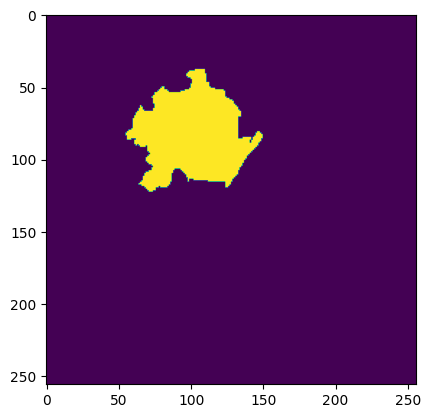

In [8]:
plt.imshow(mask_each_images[0])

In [9]:
# 이미지를 NxN으로 자름
image_cut_leng = 4

# 목표 위치를 찾는 함수
def find_target_position(mask):
    # print(mask.shape)
    grid_h, grid_w = mask.shape[0] // image_cut_leng, mask.shape[1] // image_cut_leng
    max_ones = 0
    target_position = (0, 0)
    
    for i in range(image_cut_leng):
        for j in range(image_cut_leng):
            grid = mask[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            ones_count = np.sum(grid)
            if ones_count > max_ones:
                max_ones = ones_count
                target_position = (i, j)
                
    return target_position

In [10]:
# 환경 클래스
class MRIEnv(gym.Env):
    def __init__(self, mri_images, mask_images):
        super(MRIEnv, self).__init__()
        
        self.mri_images = mri_images
        self.mask_images = mask_images
        self.grid_size = (image_cut_leng, image_cut_leng)
        self.grid_h = mri_images[0].shape[0] // self.grid_size[0]
        self.grid_w = mri_images[0].shape[1] // self.grid_size[1]
        
        self.action_space = spaces.Discrete(4) # Actions: 0 - Up, 1 - Down, 2 - Left, 3 - Right
        self.observation_space = spaces.Box(low=0, high=255, shape=(224, 224, 3), dtype=np.float32)
        
        self.current_image_index = 0
        self.current_position = (0, 0)
        self.visited_positions = set()
        self.current_grid = self._get_current_grid()
        self.target_position = find_target_position(self.mask_images)
        
    def _get_current_grid(self):
        x, y = self.current_position
        grid = self.mri_images[self.current_image_index][x*self.grid_h:(x+1)*self.grid_h, y*self.grid_w:(y+1)*self.grid_w]
        return grid
        
    def reset(self):
        self.current_image_index = random.randint(0, len(self.mri_images) - 1)
        self.current_position = (0, 0)
        self.visited_positions = set()
        self.visited_positions.add(self.current_position)
        self.current_grid = self._get_current_grid()
        self.target_position = find_target_position(self.mask_images)
        return self._preprocess(self.current_grid)
        
    def step(self, action):
        x, y = self.current_position
        if action == 0 and x > 0:  # Up
            x -= 1
        elif action == 1 and x < self.grid_size[0] - 1:  # Down
            x += 1
        elif action == 2 and y > 0:  # Left
            y -= 1
        elif action == 3 and y < self.grid_size[1] - 1:  # Right
            y += 1
        
        new_position = (x, y)
        if new_position in self.visited_positions:
            reward = -0.5  # 이미 방문한 곳 방문 시 패널티 제공
        else:
            self.visited_positions.add(new_position)
            reward = 0

        if new_position == self.target_position:
            reward += 10  # mask 위치를 찾았을 경우 보상 제공
            done = True
        else:
            reward -= 1 # 그냥 움직이는 경우 -1
            done = False
        
        self.current_position = new_position
        self.current_grid = self._get_current_grid()
        return self._preprocess(self.current_grid), reward, done, {}
    
    def _preprocess(self, grid):
        grid = tf.image.resize(grid, (224, 224))
        grid = grid / 255.0  # Normalize to [0, 1]
        return np.expand_dims(grid, axis=0)

class DQNAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        
    def _build_model(self):
        vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        for layer in vgg.layers:
            layer.trainable = False
        
        model = Sequential([
            vgg,
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=Adam(lr=self.learning_rate), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save(self, name):
        self.model.save_weights(name)
    
    def load(self, name):
        self.model.load_weights(name)

In [11]:
env = MRIEnv(mri_images[0], mask_each_images[0]) # 한 케이스에 대해서 학습
state_shape = env.observation_space.shape
action_size = env.action_space.n

agent = DQNAgent(action_size)

C:\Users\USER\anaconda3\envs\tensorflow_1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
episodes = 5
batch_size = 32
gamma = 0.95

for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, 224, 224, 3])  # VGG16 모델에 맞도록 reshape
    total_reward = 0
    start = datetime.datetime.now()
    for time in range(100):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 224, 224, 3])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            end = datetime.datetime.now()
            print(f"Episode {e + 1}/{episodes}, Time: {time}, Total Reward: {total_reward}, Processing Time: {end-start}")
            agent.update_target_model()  # target 업데이트
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
    
    # Checkpoint 저장
    if (e + 1) % 5 == 0:  # 매 5 에피소드마다 저장
        agent.save(f'checkpoint_0614_1_{e + 1}.h5')
# 예) 5 에피소드 학습

Episode 1/5, Time: 5, Total Reward: 4.0, Processing Time: 0:00:00.013514
Episode 2/5, Time: 12, Total Reward: -7.5, Processing Time: 0:00:00.028005
Episode 3/5, Time: 5, Total Reward: 3.0, Processing Time: 0:00:00.011519
Episode 4/5, Time: 2, Total Reward: 7.5, Processing Time: 0:00:00.006199
Episode 5/5, Time: 1, Total Reward: 9, Processing Time: 0:00:00.004002


Path for episode 1: [(0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 3), (2, 3), (1, 3), (0, 3), (0, 3), (1, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (0, 2), (1, 2), (1, 3), (2, 3), (2, 2)]
Path for episode 2: [(0, 0), (0, 1), (0, 1), (0, 2), (0, 1), (1, 1), (1, 2), (2, 2)]
Path for episode 3: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 1), (3, 1), (3, 1), (2, 1), (3, 1), (2, 1), (1, 1), (2, 1), (2, 2)]
Path for episode 4: [(0, 0), (0, 0), (0, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 0), (0, 0), (0, 0), (0, 1), (0, 2), (0, 2), (0, 3), (0, 3), (1, 3), (1, 3), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 3), (1, 3), (1, 3), (0, 3), (0, 2), (0, 3), (0, 3), (1, 3), (2, 3), (2, 3), (2, 2)]
Path for episode 5: [(0, 0), (0, 1), (0, 2), (0, 1), (1, 1), (2, 1), (2, 0), (3, 0), (3, 0), (3, 1), (2, 1), (2, 2)]
Path for episode 6: [(0, 0), (0, 0), (0, 0), (1, 0), (2, 0), (2, 0), (2, 1), (2, 2)]
Path for episode 7: [(0, 0), (0, 1), (0, 1

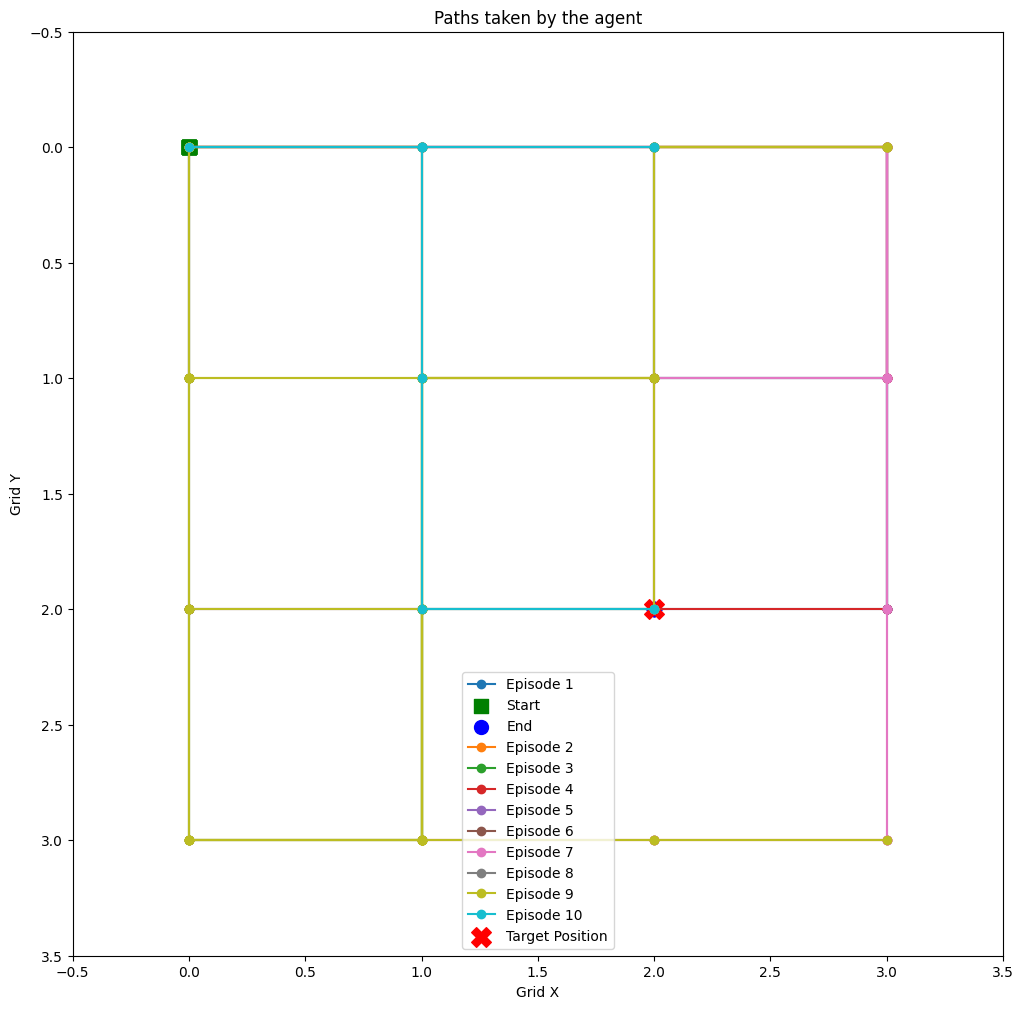

In [13]:
# 결과 시각화 함수 + 이동 경로 확인
def plot_paths(all_paths, target_position, grid_size=(4, 4)):
    plt.figure(figsize=(12, 12))
    colors = plt.cm.get_cmap('tab10', len(all_paths))
    for i, path in enumerate(all_paths):
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], marker='o', color=colors(i), label=f'Episode {i+1}')
        if len(path) > 0:
            plt.scatter(path[0, 1], path[0, 0], c='green', s=100, marker='s', label='Start' if i == 0 else "")  # 시작점
            plt.scatter(path[-1, 1], path[-1, 0], c='blue', s=100, marker='o', label='End' if i == 0 else "")  # 끝점
    plt.scatter(target_position[1], target_position[0], c='red', s=200, marker='X', label='Target Position')  # 목표 위치 표시
    plt.xlim(-0.5, grid_size[1] - 0.5)
    plt.ylim(-0.5, grid_size[0] - 0.5)
    plt.gca().invert_yaxis()
    plt.xlabel('Grid X')
    plt.ylabel('Grid Y')
    plt.title('Paths taken by the agent')
    plt.legend()
    plt.show()

# 평가 함수
def evaluate_agent(agent, env, episodes=10, max_steps_per_episode=1000):
    all_paths = []  # 이동 경로를 저장할 리스트
    for e in range(episodes):
        state = env.reset()
        path = []  # 현재 에피소드의 이동 경로
        path.append((0, 0))  # 항상 (0, 0)에서 출발
        for time in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            path.append(env.current_position)  # 현재 위치를 경로에 추가
            if done:
                break
        all_paths.append(path)  # 현재 에피소드의 경로를 저장
    return all_paths, env.target_position

# 에이전트와 환경 초기화
env = MRIEnv(mri_images[2], mask_each_images[2]) # 학습한 이미지와는 다른 이미지 선택
action_size = env.action_space.n

agent = DQNAgent(action_size)
agent.load('checkpoint_0613_1_30.h5')  # 학습된 모델 로드

# 평가
all_paths, target_position = evaluate_agent(agent, env, episodes=10, max_steps_per_episode=100)

# 이동 경로 출력
for i, path in enumerate(all_paths):
    print(f"Path for episode {i+1}: {path}")

# 경로 시각화
plot_paths(all_paths, target_position, grid_size=(4, 4))


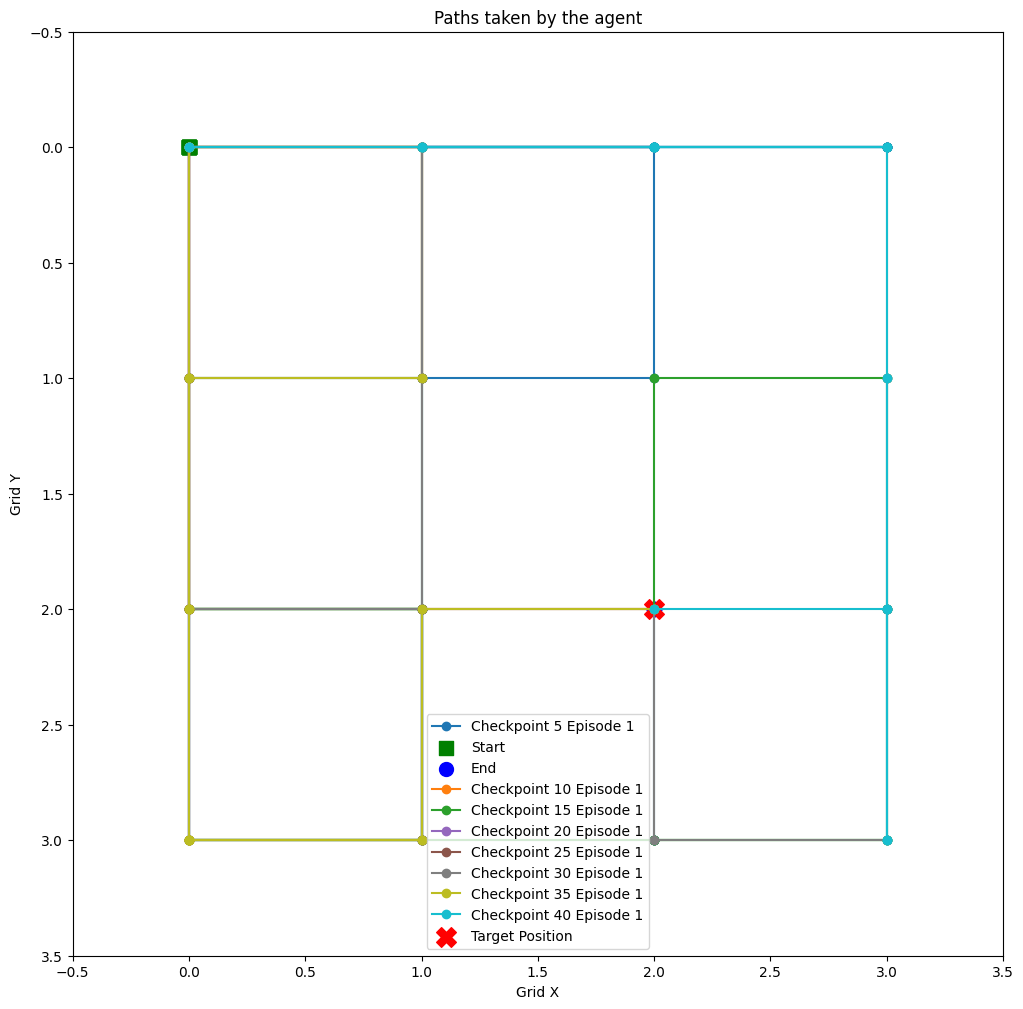

In [14]:
# 결과 시각화 함수 <- 여러 checkpoint에 대한
def plot_paths(all_paths, target_position, checkpoint_names, grid_size=(4, 4)):
    plt.figure(figsize=(12, 12))
    colors = plt.cm.get_cmap('tab10', len(all_paths))
    for i, (paths, checkpoint_name) in enumerate(zip(all_paths, checkpoint_names)):
        for j, path in enumerate(paths):
            path = np.array(path)
            plt.plot(path[:, 1], path[:, 0], marker='o', color=colors(i), label=f'{checkpoint_name} Episode {j+1}' if j == 0 else "")
            if len(path) > 0:
                plt.scatter(path[0, 1], path[0, 0], c='green', s=100, marker='s', label='Start' if i == 0 and j == 0 else "")
                plt.scatter(path[-1, 1], path[-1, 0], c='blue', s=100, marker='o', label='End' if i == 0 and j == 0 else "")
    plt.scatter(target_position[1], target_position[0], c='red', s=200, marker='X', label='Target Position')  # 목표 위치 표시
    plt.xlim(-0.5, grid_size[1] - 0.5)
    plt.ylim(-0.5, grid_size[0] - 0.5)
    plt.gca().invert_yaxis()
    plt.xlabel('Grid X')
    plt.ylabel('Grid Y')
    plt.title('Paths taken by the agent')
    plt.legend()
    plt.show()

# 평가 함수
def evaluate_agent(agent, env, episodes=10, max_steps_per_episode=1000):
    all_paths = []  # 이동 경로를 저장할 리스트
    for e in range(episodes):
        state = env.reset()
        path = []  # 현재 에피소드의 이동 경로
        path.append((0, 0))  # 항상 (0, 0)에서 출발
        for time in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            path.append(env.current_position)  # 현재 위치를 경로에 추가
            if done:
                break
        all_paths.append(path)  # 현재 에피소드의 경로를 저장
    return all_paths, env.target_position

# 에이전트와 환경 초기화
env = MRIEnv(mri_images[2], mask_each_images[2])
action_size = env.action_space.n

agent = DQNAgent(action_size)

checkpoints = [f'checkpoint_0613_1_{i}.h5' for i in range(5, 41, 5)]
# print(checkpoints)
checkpoint_names = [f'Checkpoint {i}' for i in range(5, 41, 5)]
all_paths_for_checkpoints = []

# 각 체크포인트에 대해 에이전트 평가
for checkpoint in checkpoints:
    agent.load(checkpoint)  # 학습된 모델 로드
    all_paths, target_position = evaluate_agent(agent, env, episodes=1, max_steps_per_episode=100)
    all_paths_for_checkpoints.append(all_paths)

# 경로 시각화
plot_paths(all_paths_for_checkpoints, target_position, checkpoint_names, grid_size=(4, 4))


In [15]:
# 결과 시각화 함수 <- 애니메이션으로 Gif 저장하는 함수
def plot_paths_as_animation(all_paths, target_position, checkpoint_names, grid_size=(4, 4), filename='animation.gif'):
    fig, ax = plt.subplots(figsize=(12, 12))
    colors = plt.cm.get_cmap('tab10', len(all_paths))
    
    def init():
        ax.set_xlim(-0.5, grid_size[1] - 0.5)
        ax.set_ylim(-0.5, grid_size[0] - 0.5)
        ax.invert_yaxis()
        ax.set_xlabel('Grid X')
        ax.set_ylabel('Grid Y')
        ax.set_title('Paths taken by the agent')
        ax.scatter(target_position[1], target_position[0], c='red', s=200, marker='X', label='Target Position')
        return ax,

    def update(frame):
        ax.clear()
        ax.set_xlim(-0.5, grid_size[1] - 0.5)
        ax.set_ylim(-0.5, grid_size[0] - 0.5)
        ax.invert_yaxis()
        ax.set_xlabel('Grid X')
        ax.set_ylabel('Grid Y')
        ax.set_title('Paths taken by the agent')
        ax.scatter(target_position[1], target_position[0], c='red', s=200, marker='X', label='Target Position')

        for i, (paths, checkpoint_name) in enumerate(zip(all_paths, checkpoint_names)):
            for j, path in enumerate(paths):
                path = np.array(path)
                if frame < len(path):
                    ax.plot(path[:frame+1, 1], path[:frame+1, 0], marker='o', color=colors(i), label=f'{checkpoint_name} Episode {j+1}' if frame == 0 and j == 0 else "")
                    ax.scatter(path[0, 1], path[0, 0], c='green', s=100, marker='s', label='Start' if frame == 0 and i == 0 and j == 0 else "")
                    ax.scatter(path[frame, 1], path[frame, 0], c='blue', s=100, marker='o', label='End' if frame == 0 and i == 0 and j == 0 else "")

        if frame == 0:
            ax.legend()

    max_length = max(len(path) for paths in all_paths for path in paths)
    ani = animation.FuncAnimation(fig, update, init_func=init, frames=max_length, repeat=False, blit=False)

    ani.save(filename, writer='imagemagick', fps=1)
    print(filename, "출력 완료")
    plt.close(fig)

# 평가 함수
def evaluate_agent(agent, env, episodes=10, max_steps_per_episode=1000):
    all_paths = []  # 이동 경로를 저장할 리스트
    for e in range(episodes):
        state = env.reset()
        path = []  # 현재 에피소드의 이동 경로
        path.append((0, 0))  # 항상 (0, 0)에서 출발
        for time in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            path.append(env.current_position)  # 현재 위치를 경로에 추가
            if done:
                break
        all_paths.append(path)  # 현재 에피소드의 경로를 저장
    return all_paths, env.target_position

# 에이전트와 환경 초기화
env = MRIEnv(mri_images[2], mask_each_images[2])
action_size = env.action_space.n

agent = DQNAgent(action_size)

numm = 40
checkpoints = [f'checkpoint_0613_1_{i}.h5' for i in range(numm, numm+1, 5)]
checkpoint_names = [f'Checkpoint {i}' for i in range(numm, numm+1, 5)]
all_paths_for_checkpoints = []

# 각 체크포인트에 대해 에이전트 평가
for checkpoint in checkpoints:
    agent.load(checkpoint)  # 학습된 모델 로드
    all_paths, target_position = evaluate_agent(agent, env, episodes=1, max_steps_per_episode=100)
    all_paths_for_checkpoints.append(all_paths)

# 경로 시각화를 애니메이션으로 저장
plot_paths_as_animation(all_paths_for_checkpoints, target_position, checkpoint_names, grid_size=(4, 4), filename=f'animation{numm}.gif')


MovieWriter imagemagick unavailable; using Pillow instead.


animation40.gif 출력 완료


checkpoint_0613_1_5.h5
checkpoint_0613_1_10.h5
checkpoint_0613_1_15.h5
checkpoint_0613_1_20.h5
checkpoint_0613_1_25.h5
checkpoint_0613_1_30.h5
checkpoint_0613_1_35.h5
checkpoint_0613_1_40.h5


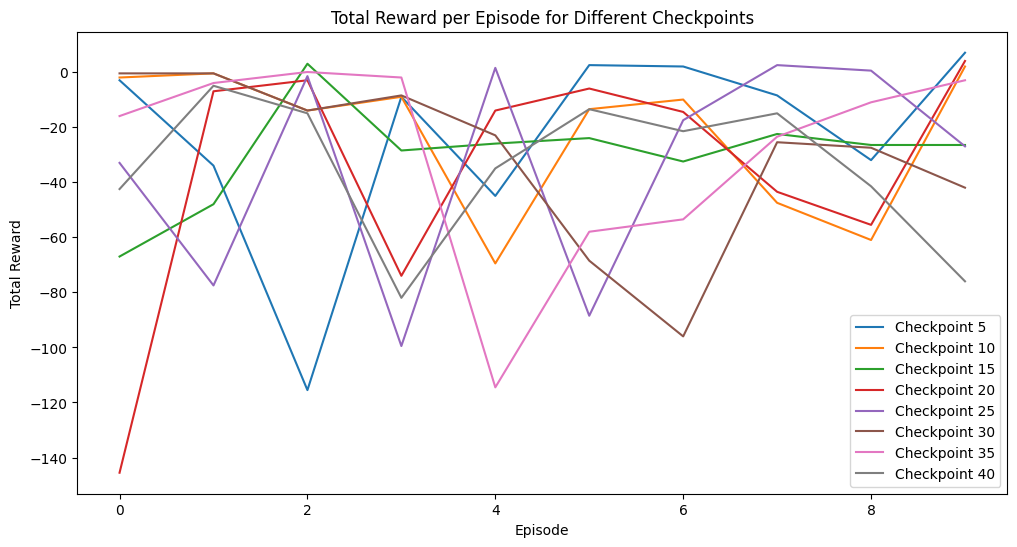

In [17]:
# 결과 Reward를 통한 시각화

# 평가 함수
def evaluate_agent_rewards(agent, env, episodes=10, max_steps_per_episode=1000):
    rewards_per_episode = []  # 에피소드별 총 보상을 저장할 리스트
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(max_steps_per_episode):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward  # 보상 누적
            if done:
                break
        rewards_per_episode.append(total_reward)  # 현재 에피소드의 총 보상을 저장
    return rewards_per_episode

# 에이전트와 환경 초기화
env = MRIEnv(mri_images[2], mask_each_images[2])
action_size = env.action_space.n

agent = DQNAgent(action_size)

checkpoints = [f'checkpoint_0613_1_{i}.h5' for i in range(5, 41, 5)]
checkpoint_names = [f'Checkpoint {i}' for i in range(5, 41, 5)]
all_rewards_for_checkpoints = []

# 각 체크포인트에 대해 평가
for checkpoint in checkpoints:
    print(checkpoint)
    agent.load(checkpoint)  # 학습된 모델 로드
    rewards_per_episode = evaluate_agent_rewards(agent, env, episodes=10, max_steps_per_episode=100)
    all_rewards_for_checkpoints.append(rewards_per_episode)

# 보상 변화 시각화
def plot_rewards(all_rewards, checkpoint_names):
    plt.figure(figsize=(12, 6))
    for i, rewards in enumerate(all_rewards):
        plt.plot(rewards, label=checkpoint_names[i])
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode for Different Checkpoints')
    plt.legend()
    plt.show()

# 보상 변화를 시각화하여 나타냄
plot_rewards(all_rewards_for_checkpoints, checkpoint_names)
